# Thesis

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Adam
from abc import ABC, abstractmethod
from random import choice
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [6]:
def closest_coord_index(coords, coord):
    return np.unravel_index(np.abs(coords - coord).sum(axis=-1).argmin(), coords.shape[:2])

def dist(w, probs, place):
    return np.sum((probs.T @ w - place)**2 * (place + 0.1))

def grid(coords, distributions):
    shape = coords.shape[:2]
    return np.asarray([dist.pdf(coords.reshape(-1, 2)).reshape(*shape)
                       for dist in distributions]).sum(axis=0) / len(distributions)

def f(x):
    a, b = x
    return sum([(a * s**-b - f)**2 for s, f in points])

points = [[0.03, 3],
          [0.003, 6],
          [0.0003, 12],
          [0.00003, 24]]

a, b = minimize(f, x0=(1, 1)).x

In [3]:
resolution = 400
MIN, MAX = -1, 1

x, y = np.linspace(MIN, MAX, resolution), np.linspace(MIN, MAX, resolution)
xx, yy = np.meshgrid(x, y)
coords = np.concatenate([xx[:,:,np.newaxis], yy[:,:,np.newaxis]], axis=-1)

In [4]:
frequencies = range(3, 8)
probs = list()
for freq in frequencies:
    size = (a / freq)**(b**-1)
    COV = np.eye(2) * size
    offsets = [0, 0.9 * (MAX - MIN) / (freq - 1) / 2] * (freq // 2) + ([0] if freq % 2 == 1 else [])
    
    for _ in range(30):
        x_phase, y_phase = np.random.normal(0, 1/freq, 2)
        mvns = [multivariate_normal(mean=[x + x_phase - offset, y + y_phase], cov=COV)
                for y, offset in zip(np.linspace(0.9 * MIN, 0.9 * MAX, freq), offsets)
                for x in np.linspace(0.9 * MIN, 0.9 * MAX + 2 * offset, int(freq + np.sign(offset)))]

        probs.append(grid(coords, mvns))
probs = np.asarray([p / p.max() for p in probs])

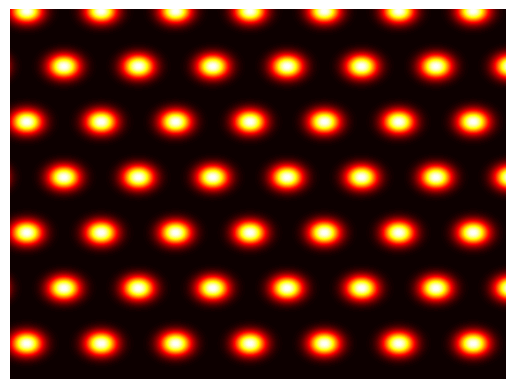

In [96]:
plt.contourf(probs[-3], levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [7]:
coord = [0, 0]
mvn = multivariate_normal(mean=coord, cov=np.eye(2) * 0.001)
place = grid(coords, [mvn])
place /= place.max()

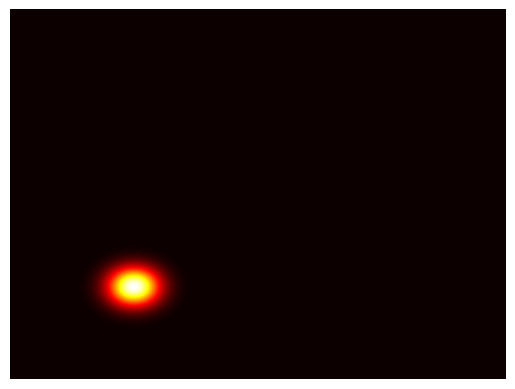

In [97]:
plt.contourf(place, levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [8]:
w = minimize(dist, x0=np.random.randn(len(probs)), args=(probs, place)).x

idx = closest_coord_index(coords, coord)
w @ probs[:,*idx]

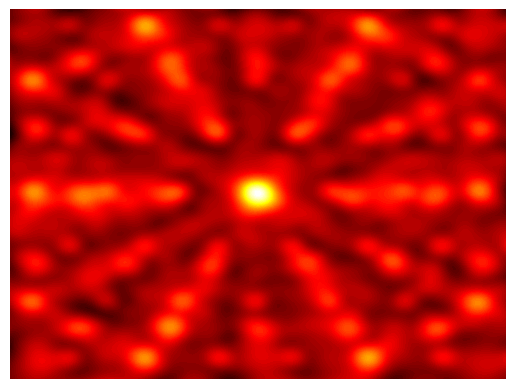

In [46]:
plt.contourf(expit(probs.T @ w).T, levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [16]:
t = probs.T @ w
t.max()

0.34322088348244706

In [72]:
p = torch.tensor(probs, dtype=torch.float32, device=device).permute((1, 2, 0))
v = torch.randn(len(probs), requires_grad=True, device=device)
pl = torch.tensor(place, dtype=torch.float32, device=device)
lr = 1e-5

for _ in tqdm(range(10000)):
    loss = torch.sum((p @ v - pl)**2 * (pl + 0.1))
    loss.backward(inputs=[v])
    v = v - lr * v.grad

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:18<00:00, 634.07it/s]


In [73]:
(p @ v).max()

tensor(0.4131, device='cuda:0', grad_fn=<MaxBackward1>)

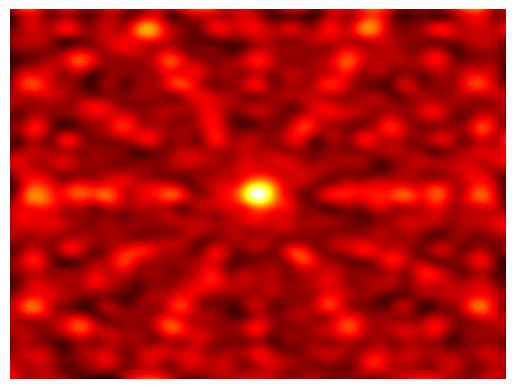

In [74]:
# plt.contourf(nn.functional.sigmoid(p @ v).detach().cpu(), levels=100, cmap='hot')
plt.contourf((p @ v).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [84]:
coord = [-.5, -.5]
mvn = multivariate_normal(mean=coord, cov=np.eye(2) * 0.005)
place = grid(coords, [mvn])
place /= place.max()

In [85]:
p = torch.tensor(probs, dtype=torch.float32, device=device).permute((1, 2, 0))
v = torch.randn(len(probs), requires_grad=True, device=device)
pl = torch.tensor(place, dtype=torch.float32, device=device)
lr = 1e-5

for _ in tqdm(range(30000)):
    loss = torch.sum((p @ v - pl)**2 * (pl + 0.1))
    loss.backward(inputs=[v])
    v = v - lr * v.grad

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:47<00:00, 629.87it/s]


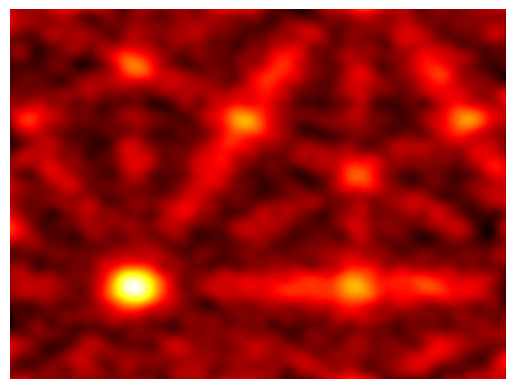

In [91]:
plt.contourf(nn.functional.sigmoid(p @ v).detach().cpu(), levels=100, cmap='hot')
# plt.contourf((p @ v).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [2]:
class Environment(ABC):
    @abstractmethod
    def next_state(self):
        ...
    
    @abstractmethod
    def reset(self):
        ...

In [3]:
class GridWorld(Environment):
    VELOCITIES = [-1, 0, 1]
    
    def __init__(self, x, y):
        assert x >= 2 and y >= 2, f"GridWorld must be at least 2x2, got {x}x{y}"
        assert isinstance(x, int) and isinstance(y, int), f"Dimensions must be integers, got type(x)={type(x)} and type(y)={type(y)}"
        self.states = np.arange(x*y).reshape(x, y)
        self.reset()
    
    def reset(self):
        self.state = np.random.choice(self.states.flatten())
    
    def next_state(self):
        x, y = np.where(self.states == self.state)
        vx, vy = self.possible_velocity(x.item(), y.item())
        x += vx
        y += vy
        self.state = self.states[x, y].item()
    
    def possible_velocity(self, x, y):
        vx = choice(self.VELOCITIES[int(x == 0):-1 if x == self.states.shape[0] - 1 else len(self.VELOCITIES)])
        vy = choice(self.VELOCITIES[int(y == 0):-1 if y == self.states.shape[1] - 1 else len(self.VELOCITIES)])
        return vx, vy

In [4]:
class ToroidalGridWorld(GridWorld):
    def next_state(self):
        old = self.state
        x, y = np.where(self.states == old)
        vx, vy = self.possible_velocity()
        x = (x + vx) % self.states.shape[0]
        y = (y + vy) % self.states.shape[1]
        self.state = self.states[x, y].item()
        return old, vx, vy, self.state
    
    def possible_velocity(self):
        return choice(self.VELOCITIES), choice(self.VELOCITIES)

In [5]:
# Net types: 'conv' or 'lin'
def generate_data(x, y, size=10000, net_type='conv'):
    allowed = ['conv', 'lin']
    assert net_type in allowed, f"Network type must be one of {allowed}. Got {net_type}"
    
    data = np.asarray([ToroidalGridWorld(x, y).next_state() for _ in range(size)])
    data, targets = data[:,:3], data[:,3]
    
    data = process_data_for_conv(data, x, y) if net_type == 'conv' \
        else np.hstack([encode(data[:,0]).toarray(), data[:,1:]])
    
    return data, targets
    

def encode(x):
    return OneHotEncoder().fit_transform(x.reshape(-1, 1))

def process_data_for_conv(data, x, y):
    t = encode(data[:,0]).toarray().reshape(-1, x, y)
    velocity = np.zeros(list(t.shape) + [2])
    velocity[t.astype(bool)] = data[:,[1,2]]
    t = np.concatenate([np.expand_dims(t, -1), velocity], axis=-1)
    t = np.concatenate([t[:,:,[-1]], t, t[:,:,[0]]], axis=2)
    t = np.concatenate([t[:,[-1],:], t, t[:,[0],:]], axis=1)
    return np.moveaxis(t, -1, 1)

def get_batch_indices(size, bs):
    return np.split(np.random.permutation(np.arange(size)), range(bs, size, bs))

def evaluate(net, x, y, size=10000, net_type='conv', verbose=False):
    data, targets = generate_data(x, y, size=size, net_type=net_type)
    
    pred = net(torch.tensor(data, device=device, dtype=torch.float32))
    target = torch.tensor(targets, device=device, dtype=torch.long)
    loss = criterion(pred, target).detach().cpu().item()
    if verbose: print(loss)
    return loss

def train(net, optim, data, targets, epochs, x, y, bs=64, net_type='conv', verbose=False):
    for e in tqdm(range(epochs), disable=verbose):
        for bidx in tqdm(get_batch_indices(len(data), bs), disable=not verbose):
            net.zero_grad()
            pred = net(torch.tensor(data[bidx], device=device, dtype=torch.float32))
            target = torch.tensor(targets[bidx], device=device, dtype=torch.long)
            loss = criterion(pred, target)
            loss.backward()
            optim.step()
        yield evaluate(net, x, y, net_type=net_type, verbose=verbose)

In [6]:
x, y = 5, 5
size = 100000
bs = 256
EPOCHS = 30

In [7]:
perceptron = nn.Linear(x * y + 2, x * y).to(device)
conv = nn.Sequential(
    nn.Conv2d(3, 1, 3, stride=1),
    nn.Flatten()
).to(device)

optim_p = Adam([p for p in perceptron.parameters()], lr=3e-3)
optim_c = Adam([p for p in conv.parameters()], lr=3e-3)
criterion = nn.CrossEntropyLoss()

In [8]:
data, targets = generate_data(x, y, size=size)
losses_c = [evaluate(conv, x, y)] + [l for l in train(conv, optim_c, data, targets, EPOCHS, x, y, bs)]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:41<00:00,  1.39s/it]


In [9]:
data, targets = generate_data(x, y, size=size, net_type='lin')
losses_l = [evaluate(perceptron, x, y, net_type='lin')] + \
           [l for l in train(perceptron, optim_p, data, targets, EPOCHS, x, y, bs, 'lin')]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.04it/s]


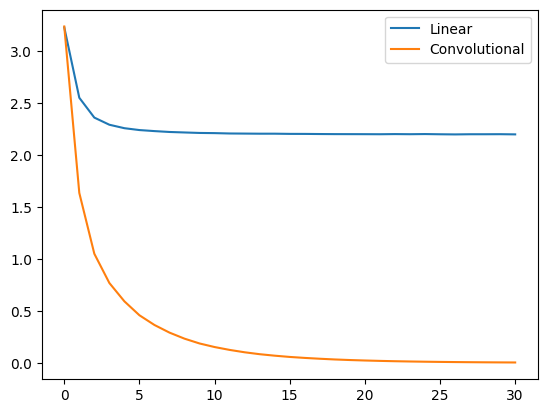

In [11]:
plt.plot(losses_l, label="Linear")
plt.plot(losses_c, label="Convolutional")
plt.legend()
plt.show()